# 实验4 图像特征提取和匹配

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import numpy as np

### 1. 使用SIFT特征点提取和匹配，拼接“b1.png”和“b2.png”

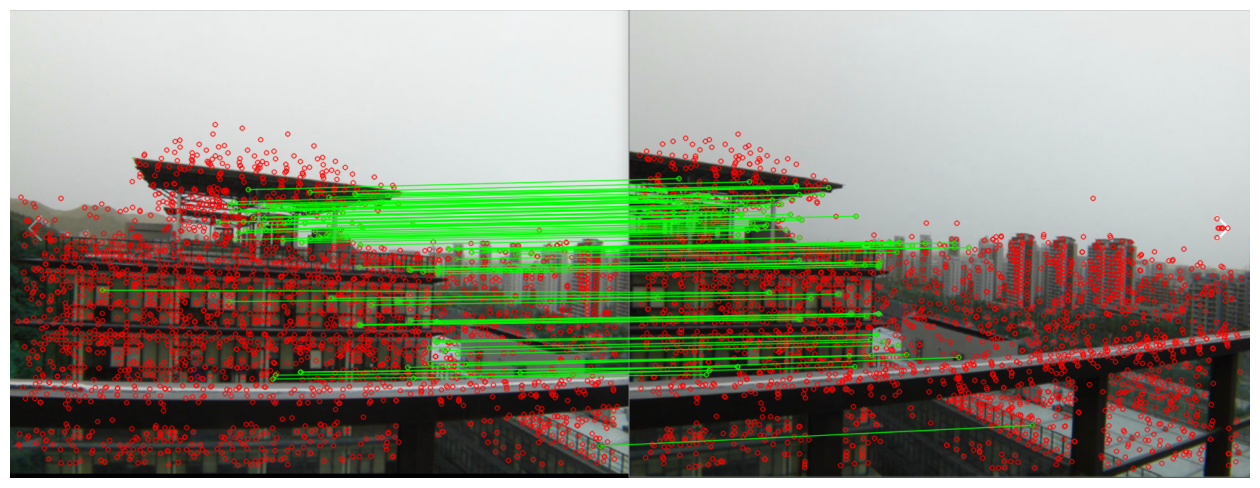

左图：2672，右图：2470
匹配：2672，优选：910


In [2]:
left_image = cv2.imread('./SIFT/b1.png')
right_image = cv2.imread('./SIFT/b2.png')

# SIFT, opencv/opencv-contrib >= 4.4.0
# left_keypoints, left_descriptions = cv2.SIFT_create().detectAndCompute(left_image, None)
# right_keypoints, right_descriptions = cv2.SIFT_create().detectAndCompute(right_image, None)

# SIFT, opencv-contrib < 4.4.0
# left_keypoints, left_descriptions = cv2.xfeatures2d_SIFT.create().detectAndCompute(left_image, None)
# right_keypoints, right_descriptions = cv2.xfeatures2d_SIFT.create().detectAndCompute(right_image, None)

# SURF, opencv-contrib < 3.4.3
left_keypoints, left_descriptions = cv2.xfeatures2d_SURF.create(upright=True).detectAndCompute(left_image, None)
right_keypoints, right_descriptions = cv2.xfeatures2d_SURF.create(upright=True).detectAndCompute(right_image, None)

matches = (cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50))
              .knnMatch(left_descriptions, right_descriptions, k=2))

matches_similarity = 0.75
matches_good = [l for l, r in matches if l.distance < (matches_similarity * r.distance)]

plt.figure(figsize=(16, 9), dpi=100)
plt.imshow(cv2.drawMatchesKnn(left_image, left_keypoints,
                              right_image, right_keypoints,
                              matches, None,
                              matchColor=(0, 255, 0), singlePointColor=(255, 0, 0),
                              matchesMask=[[1,0]
                                           if match[0] in matches_good[:100]
                                           else [0,0]
                                           for match in matches]))
plt.axis('off')
plt.show()

print(f'左图：{len(left_keypoints)}，右图：{len(right_keypoints)}')
print(f'匹配：{len(matches)}，优选：{len(matches_good)}')

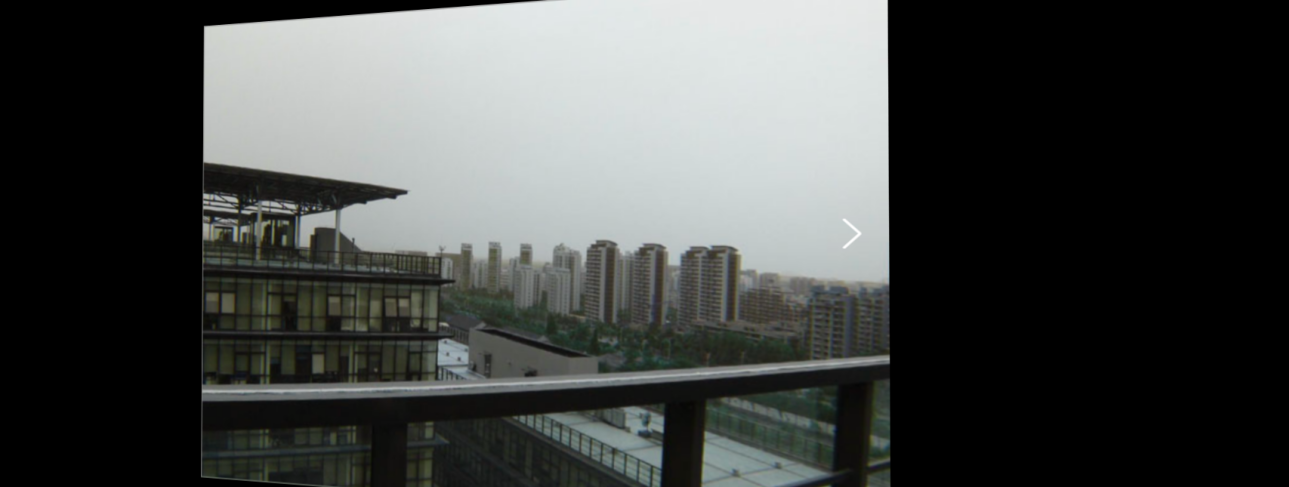

In [3]:
keypoints_matched_position = np.array([[left_keypoints[match.queryIdx].pt, right_keypoints[match.trainIdx].pt]
                                        for match in matches_good])

trans_matrix, _ = cv2.findHomography(keypoints_matched_position[:, 0][:, np.newaxis],
                                     keypoints_matched_position[:, 1][:, np.newaxis],
                                     method=cv2.RANSAC, ransacReprojThreshold=5)

src_pts = np.float32([left_keypoints[m.queryIdx].pt for m in matches_good]).reshape(-1, 1, 2)
ano_pts = np.float32([right_keypoints[m.trainIdx].pt for m in matches_good]).reshape(-1, 1, 2)
trans_matrix, _ = cv2.findHomography(src_pts, ano_pts, cv2.RANSAC, 5.0)

warp_image = cv2.warpPerspective(right_image, np.linalg.inv(trans_matrix),
                                 (left_image.shape[1] + right_image.shape[1], right_image.shape[0]))

plt.figure(figsize=(warp_image.shape[1], warp_image.shape[0]), dpi=1)
plt.imshow(warp_image)
plt.axis('off')
plt.show()

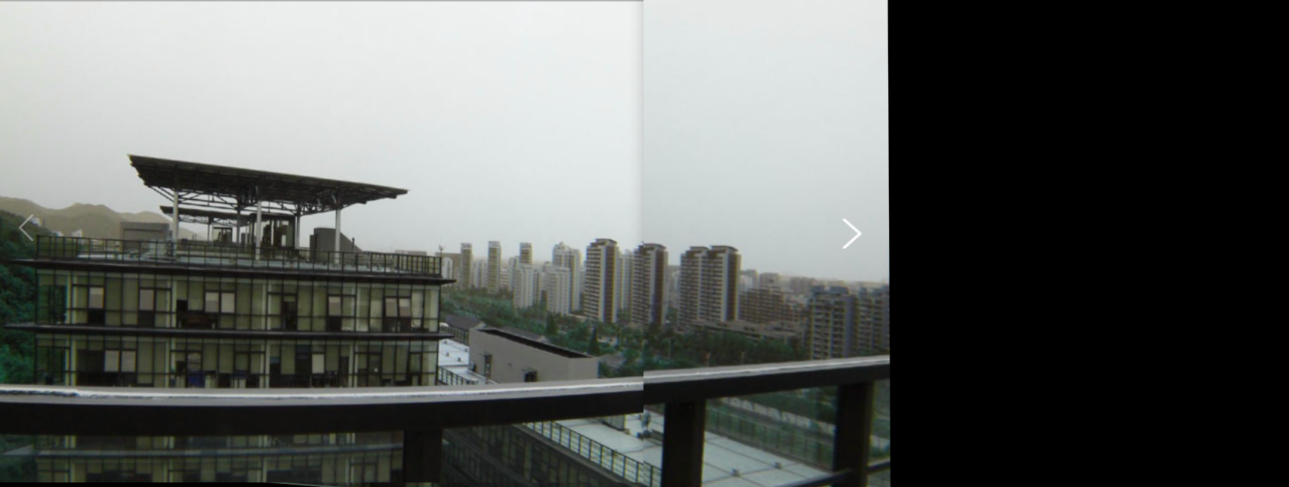

In [4]:
splice_image = warp_image.copy()
splice_image[0:left_image.shape[0], 0:left_image.shape[1]] = left_image

plt.figure(figsize=(splice_image.shape[1], splice_image.shape[0]), dpi=1)
plt.imshow(splice_image)
plt.axis('off')
plt.show()

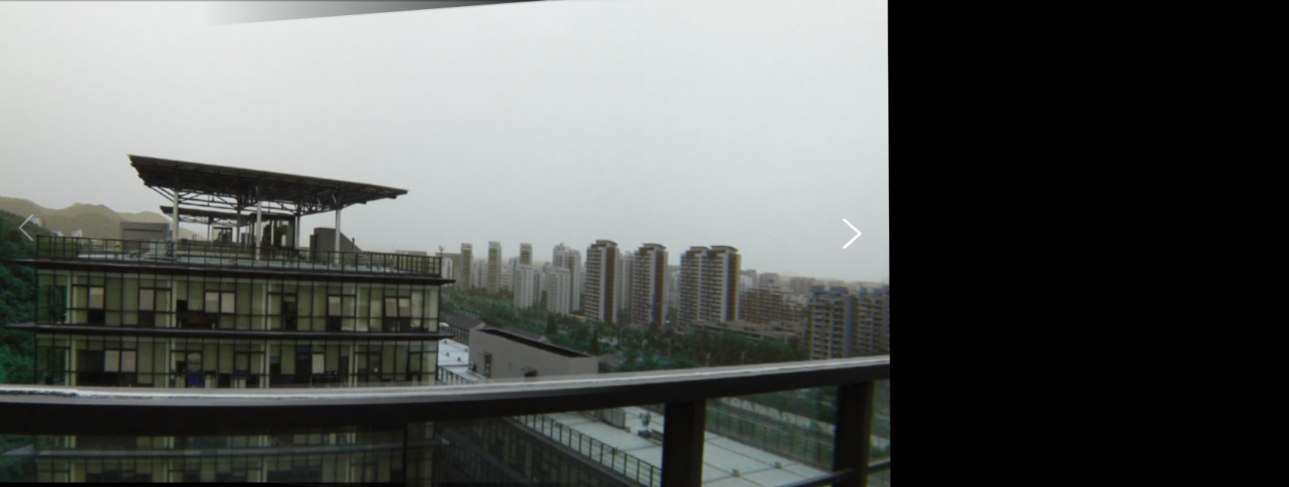

In [5]:
overlap_left = np.argmax(warp_image.any(axis=2).any(axis=0)) # get first non-black col num
overlap_right = left_image.shape[1]

overlap_image = np.zeros([right_image.shape[0], overlap_right - overlap_left, 3])
overlap_image[: left_image.shape[0], :] = left_image[:, overlap_left : overlap_right]

alpha = np.linspace(0, 1, overlap_right - overlap_left).reshape(1, -1, 1)

overlap_image = overlap_image * (1 - alpha) + warp_image[:, overlap_left: overlap_right] * alpha

blended_image = splice_image.copy()
blended_image[:, overlap_left : overlap_right] = overlap_image

plt.figure(figsize=(blended_image.shape[1], blended_image.shape[0]), dpi=1)
plt.imshow(blended_image)
plt.axis('off')
plt.show()

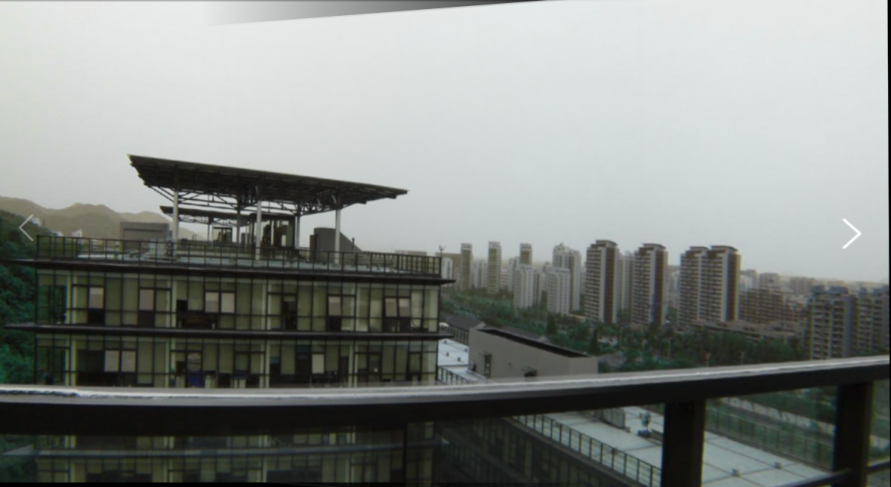

In [6]:
cutoff_image = blended_image.copy()
cutoff_edge = np.argmin(blended_image.any(axis=2).any(axis=0)) # get first black col num
cutoff_image = cutoff_image[:, : cutoff_edge]

plt.figure(figsize=(cutoff_image.shape[1], cutoff_image.shape[0]), dpi=1)
plt.imshow(cutoff_image)
plt.axis('off')
plt.show()

### 2. 参考附件“对象提取.doc”，使用形态学运算提取图像“car.png”中的车牌对象。

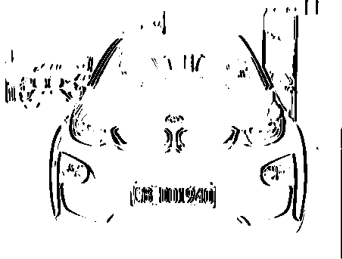

In [7]:
car_image = cv2.imread('./car.png')

gray_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

sobel_x = cv2.Sobel(cv2.GaussianBlur(gray_image, (3, 3), 0),
                    cv2.CV_16S, 1, 0)

_, binary_image = cv2.threshold(cv2.convertScaleAbs(sobel_x), 0, 255, cv2.THRESH_OTSU)

plt.figure(figsize=(binary_image.shape[1], binary_image.shape[0]), dpi=1)
plt.imshow(binary_image, cmap='binary')
plt.axis('off')
plt.show()

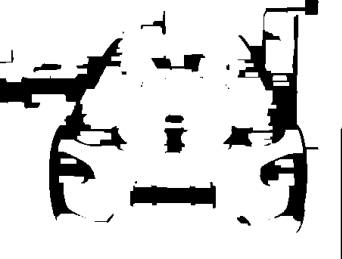

In [8]:
kernel_x = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
closing_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel_x)

plt.figure(figsize=(closing_image.shape[1], closing_image.shape[0]), dpi=1)
plt.imshow(closing_image, cmap='binary')
plt.axis('off')
plt.show()

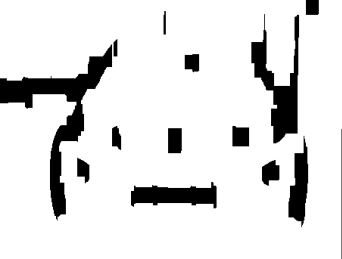

In [9]:
kernel_x = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
kernel_y = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 19))

morphology_image = closing_image.copy()
morphology_image = cv2.dilate(morphology_image, kernel_x)
morphology_image = cv2.erode(morphology_image, kernel_x)
morphology_image = cv2.erode(morphology_image, kernel_y)
morphology_image = cv2.dilate(morphology_image, kernel_y)

plt.figure(figsize=(morphology_image.shape[1], morphology_image.shape[0]), dpi=1)
plt.imshow(morphology_image, cmap='binary')
plt.axis('off')
plt.show()

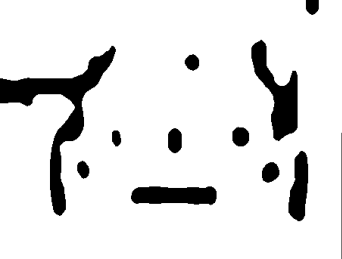

In [10]:
morphology_image = cv2.medianBlur(morphology_image, 15)

plt.figure(figsize=(morphology_image.shape[1], morphology_image.shape[0]), dpi=1)
plt.imshow(morphology_image, cmap='binary')
plt.axis('off')
plt.show()

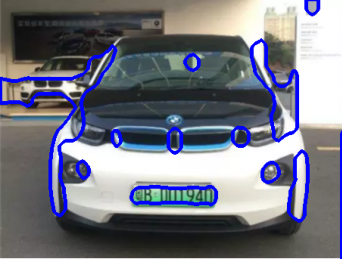

In [11]:
# for opencv < 4.0
# _, contours, _ = cv2.findContours(morphology_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# for opencv >= 4.0
contours, _ = cv2.findContours(morphology_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

targets_rectangles = [cv2.boundingRect(contour) for contour in contours]

plt.figure(figsize=(car_image.shape[1], car_image.shape[0]), dpi=1)

plt.imshow(cv2.drawContours(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB),
                            contours, -1, (0, 0, 255), 3))

plt.axis('off')
plt.show()

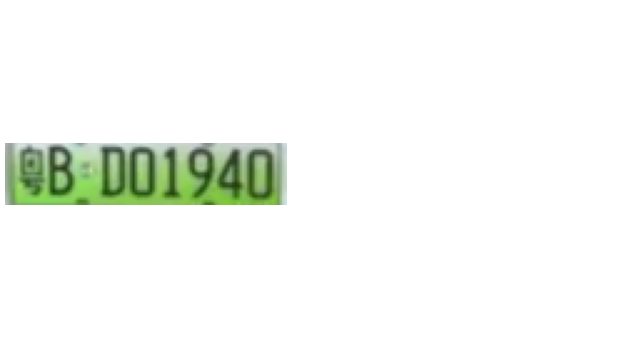

In [12]:
targets = [target for target in targets_rectangles if target[2] > (target[3] * 2)]
targets = [car_image[target[1] : target[1] + target[3], # y : y + height
                     target[0] : target[0] + target[2]] # x : x + weight
           for target in targets]

fig, ax = plt.subplots(1, len(targets) + 1, figsize=(16, 9), dpi=50)

[ax[i].imshow(t) for i, t in enumerate(targets)]

[a.axis('off') for a in ax]
plt.show()